In [1]:
# You don't have to reload on each library update
%load_ext autoreload
%autoreload 2
%matplotlib inline

import tensorflow as tf

from methods import *
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, add
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.regularizers import l2

from tensorflow.python.client import device_lib

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(gpus)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
augmented_imgs_path = 'D:/20.share/jaehochang/SP2Robotics/videos/'
args = {'IMAGES': []} 
for root, dirs, files in os.walk(augmented_imgs_path):
    for file in files:
        args['IMAGES'].append(os.path.join(root, file))

augmenters_c = {
    'Env':{
        'Snowy': ia.FastSnowyLandscape(lightness_threshold=150, lightness_multiplier=2.5),
#         'Clouds': ia.Clouds(),
#         'Fog': ia.Fog(),
#         'Snowflakes': ia.Snowflakes(flake_size=(0.1, 0.4), speed=(0.01, 0.05)),
#         'Rain': ia.Rain(drop_size=(0.10, 0.20), speed=(0.1, 0.3)),
#         'Darken': ia.Multiply(.3, per_channel=.5)
    },
    'Trs':{
#         'GN': ia.AdditiveGaussianNoise(loc=0, scale=(0.0, 1/10*255), per_channel=0.2),
#         'VertFlip': ia.Flipud(),
#         'HorizFlip': ia.HorizontalFlip(),
#         'Rotate': ia.Rotate(rotate=(-45, 45)),
#         'Zoom': ia.Affine(scale={"x": (1, 1.5), "y": (1, 1.5)})
    }
}

### Read video

In [5]:
factor = 10
h, w = 9 * 4 * factor, 16 * 4 * factor
    
frames, aimgs = prprdata(w, h, 4, args['IMAGES'][:1], augmenters_c)

Resize(name=UnnamedResize, parameters=[(Deterministic(int 360), Deterministic(int 640)), Deterministic(cubic), HW], deterministic=False)


In [6]:
import pandas as pd
pd.to_pickle(frames, 'frames.pkl'), pd.to_pickle(aimgs, 'aimgs.pkl')
frames, aimgs = pd.read_pickle('frames.pkl'), pd.read_pickle('aimgs.pkl')

In [7]:
fa = np.asarray([*zip(frames, aimgs)])
fa.shape

(1999, 2, 360, 640, 3)

### Noisy vs. Clean train image

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x15c4b7fa250>)

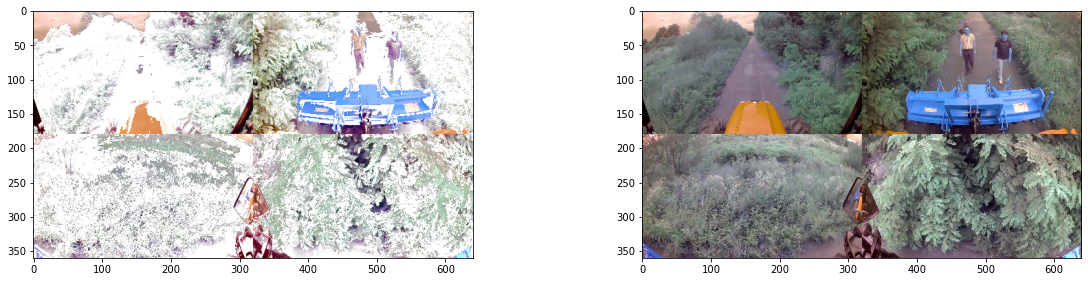

In [8]:
from sklearn import model_selection
X_trains, X_tests = [], []

X_train, X_test = model_selection.train_test_split(fa, test_size = 0.4)
X_train, X_test = np.asarray(X_train), np.asarray(X_test)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

idx = 289
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 2), plt.imshow(X_train[idx][0])
plt.subplot(2, 2, 1), plt.imshow(X_train[idx][1])

In [9]:
X_train.shape, X_test.shape

((1199, 2, 360, 640, 3), (800, 2, 360, 640, 3))

## 2. Denoising autoencoder

### Create the network

In [18]:
with tf.device('/GPU:0'):
    x = keras.layers.Input(shape=X_train[0,0].shape)
    
    # Encoder
    io = BatchNormalization()(
        Conv2D(30, (3, 3), activation='relu', padding='same', name = 'conv1_1')(x)
    )
#     io = BatchNormalization()(
#         MaxPooling2D((2, 2), padding='same', name = 'pool1')(io)
#     )
    io = BatchNormalization()(
        Conv2D(30, (3, 3), activation='relu', padding='same', name = 'conv1_2')(io)
    )
    io = BatchNormalization()(
        MaxPooling2D((2, 2), padding='same', name = 'h')(io)
    )

    # Decoder
    io = BatchNormalization()(
        Conv2D(30, (3, 3), activation='relu', padding='same')(io)
    )
    io = BatchNormalization()(
        UpSampling2D((2, 2))(io)
    )
    io = BatchNormalization()(
        Conv2D(30, (3, 3), activation='relu', padding='same')(io)
    )
#     io = BatchNormalization()(
#         UpSampling2D((2, 2))(io)
#     )
    r = Conv2D(3, (3, 3), activation='linear', padding='same')(io)

    optmz = keras.optimizers.SGD()
    loss = keras.losses.MeanSquaredError()
    
    autoencoder = Model(inputs=x, outputs=r)
    autoencoder.compile(optmz, loss)

    epochs = 5000
    batch_size = 16
    
    print(autoencoder.summary())

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 360, 640, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 360, 640, 30)      840       
_________________________________________________________________
batch_normalization_12 (Batc (None, 360, 640, 30)      120       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 360, 640, 30)      8130      
_________________________________________________________________
batch_normalization_13 (Batc (None, 360, 640, 30)      120       
_________________________________________________________________
h (MaxPooling2D)             (None, 180, 320, 30)      0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 180, 320, 30)     

In [ ]:
history = autoencoder.fit(X_train[:, 1], X_train[:, 0],  # noisy train, train
                          batch_size=batch_size, epochs=epochs, verbose=True, 
                          validation_data=(X_test[:, 1], X_test[:, 0]))

decoded_imgs = autoencoder.predict(X_test[:, 1], batch_size=batch_size)

Epoch 1/5000
75/75 [==============================] - 21s 275ms/step - loss: 0.3739 - val_loss: 0.0615
Epoch 2/5000
75/75 [==============================] - 20s 262ms/step - loss: 0.0795 - val_loss: 0.0449
Epoch 3/5000
75/75 [==============================] - 20s 260ms/step - loss: 0.0537 - val_loss: 0.0570
Epoch 4/5000
75/75 [==============================] - 19s 260ms/step - loss: 0.0445 - val_loss: 0.0514
Epoch 5/5000
75/75 [==============================] - 19s 260ms/step - loss: 0.0399 - val_loss: 0.0429
Epoch 6/5000
75/75 [==============================] - 19s 259ms/step - loss: 0.0363 - val_loss: 0.0360
Epoch 7/5000
75/75 [==============================] - 19s 259ms/step - loss: 0.0340 - val_loss: 0.0326
Epoch 8/5000
75/75 [==============================] - 19s 259ms/step - loss: 0.0324 - val_loss: 0.0306
Epoch 9/5000
75/75 [==============================] - 19s 260ms/step - loss: 0.0312 - val_loss: 0.0296
Epoch 10/5000
75/75 [==============================] - 19s 259ms/step - l

In [ ]:
autoencoder.save('e5000')

### Plot

In [ ]:
plt.figure(figsize=(20, 20))
for i, j in enumerate([122]):
    # display original
    ax = plt.subplot(1, 2, 1)
    plt.imshow(X_test[:, 0][j])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(1, 2, 2)
    plt.imshow(decoded_imgs[j])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Scrutinize

In [ ]:
h = history.model.layers[1].output
activation_model = tf.keras.models.Model(inputs = autoencoder.input, outputs = h)
activations = activation_model.predict(np.expand_dims(X_test[:, 1][22], axis = 0))
print(activations[0].shape)
plt.imshow(activations[0][:, :, 1:2])
# plt.show()

---

---